In [1]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from sklearn.cluster import KMeans
from umap import UMAP

from source.experiments.eval_utils import (
    load_configs_df,
    load_discovery_result,
    load_concept_activations,
    load_alignment_results,
    process_validity,
    load_groundtruth,
)
from source.experiments.alignment import alignment_sanity_check_score

/opt/anaconda3/envs/nlmcd-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# NLMCD

In this notebook, we will

- run concept discovery for all blocks of the MAE model
- measure alignment between all pairs of representations
- measure fine-grained concept-based alignment between selected pairs of representations

# Run concept discovery

Run NLMCD concept discovery for block 11 of the MAE model:
```bash        
run_id=001   # give each run a unique identifier digit-code 

root='path/to/imagenet'
exp_dir='path/to/discovery/experiment/results'

model='vit_base_patch16_224.mae'
feature_layer=11

vcl=umap    # or 'ident' for other discovery methods 
discovery=hdbscan    # or other discovery methods: 'kmeans', 'mcd', 'pca'

python executable_scripts/concept_discovery.py  run_id=$run_id \
                                                exp_dir=$exp_dir \
                                                dataset.params.root=$root \
                                                dataset.params.representation_model_ckpt=$representation_model_ckpt \
                                                dataset.params.feature_layer=$feature_layer \
                                                vcl.name=$vcl \
                                                vcl.cluster.discovery=$discovery
```

Load the concept discovery results

In [2]:
# load configs
exp_dir = "../results/concept_discovery/extracted/"

date = "2024-10-11_15-00-00"
measured = ["n_cluster", "n_noise", "n_sample", "rmse"]
df = load_configs_df(exp_dir, start_date=date, measured=measured)
df["noise_ratio"] = df["n_noise"] / df["n_sample"]

df.set_index("run_id", inplace=True)

# load validity results
df["validity_train_result"] = df["config_path"].apply(
    lambda config_path: load_discovery_result(
        config_path, exp_dir, name="validity_train.pkl"
    )
)
df["dbcv"] = df["validity_train_result"].apply(
    lambda val: process_validity(val, "embedded", "overall_cluster")
)


# load intrinsic dimensionality results
df["ID_result"] = df["config_path"].apply(
    lambda config_path: load_discovery_result(
        config_path, exp_dir, name="intrinsic_dimension_train.pkl"
    )
)
df["ID_mean"] = df["ID_result"].apply(
    lambda ids: np.mean(
        [ids["hard_clustering"][k] for k in ids["hard_clustering"] if k != -1]
    )
)

config df shape (11, 49)


Plot concept discovery quality metrics (excluding robustness, for which we need a second run concept discovery run)

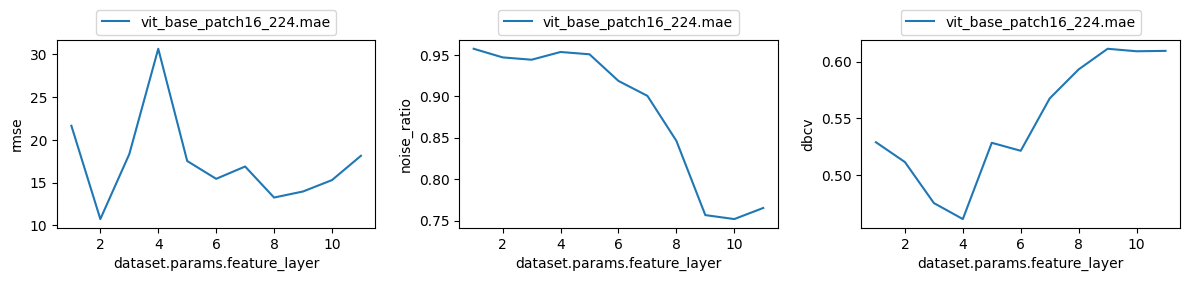

In [4]:
# Plot RMSE, noise rate, validity
indexers = ["dataset.params.representation_model_ckpt", "dataset.params.feature_layer"]

measures = ["rmse", "noise_ratio", "dbcv"]
fig, ax = plt.subplots(1, len(measures), figsize=(12, 3))
for i, measure in enumerate(measures):
    df.set_index(indexers)[measure].unstack(level=0).plot(ax=ax[i])
    ax[i].set_ylabel(measure)
    ax[i].legend(loc="upper center", bbox_to_anchor=(0.5, 1.2))
plt.tight_layout()

Plot concept count and intrinsic dimensionality

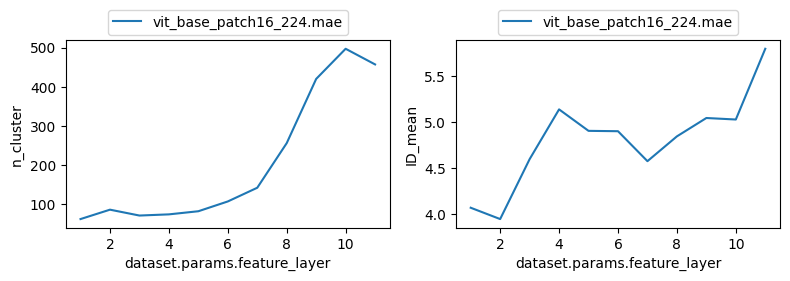

In [5]:
# Plot concept count and intrinsic dimensionality

indexers = ["dataset.params.representation_model_ckpt", "dataset.params.feature_layer"]

measures = ["n_cluster", "ID_mean"]
fig, ax = plt.subplots(1, len(measures), figsize=(8, 3))
for i, measure in enumerate(measures):
    df.set_index(indexers)[measure].unstack(level=0).plot(ax=ax[i])
    ax[i].set_ylabel(measure)
    ax[i].legend(loc="upper center", bbox_to_anchor=(0.5, 1.2))
plt.tight_layout()

Load alignment results

# Run alignment

#### Alignment heatmap

Evaluate concept-based alignment between all blocks of the MAE model:
```bash
run_id=101

cfg_dir='path/to/discovery/experiment/results'
exp_dir='path/to/alignment/experiment/results'  

vcl='umap_hdbscan_50-20_1-0.01-0.25'
cluster_assignment='hdbscan'
model='vit_base_patch16_224.mae'

python executable_scripts/evaluate_alignment.py     run_id=$run_id \
                                                    vcl=$vcl \
                                                    vcl2=$vcl \
                                                    cluster_assignment1=$cluster_assignment \
                                                    cluster_assignment2=$cluster_assignment \
                                                    model1=$model \
                                                    model2=$model \
```


#### Alignment with groundtruth (ImageNet-1k labels)
Evaluate aligment between concepts and groundtruth labels
```bash
python executable_scripts/evaluate_alignment.py     run_id=$run_id \
                                                    vcl=$vcl \
                                                    vcl2=$vcl \
                                                    cluster_assignment1=$cluster_assignment \
                                                    cluster_assignment2=$cluster_assignment \
                                                    model1=$model \
                                                    model2=groundtruth    # second model is called 'groundtruth' in this case
```

#### Robustness

Evaluate alignment between concepts of two different runs - requires second concept discovery run with same hyperparameters.
```bash
vcl1='umap_hdbscan_50-20_1-0.01-0.25_0'
vcl2='umap_hdbscan_50-20_1-0.01-0.25_1'
python executable_scripts/evaluate_alignment.py         run_id=$run_id \
                                                        vcl="$vcl1" \
                                                        vcl2="$vcl2" \
                                                        cluster_assignment1="$cluster_assignment" \
                                                        cluster_assignment2="$cluster_assignment" \
                                                        model1="$model" \
                                                        model2="$model" \
                                                        numerate_duplicates=True \
                                                        only_same_layer=True
```



#### Concept-wise alignment
Evaluate pairwise distance between concepts of model1 at block fl1 and model2 at block fl2.
```bash
python executable_scripts/evaluate_alignment.py         run_id=$run_id \
                                                        vcl="$vcl" \
                                                        vcl2="$vcl" \
                                                        cluster_assignment1="$cluster_assignment" \
                                                        cluster_assignment2="$cluster_assignment" \
                                                        model1="$model" \
                                                        model2="$model" \
                                                        clusterwise=True \
                                                        fl1=11 \   # blocks between which to measure fine-grained concept alignment
                                                        fl2=11 
```                                                      


Load concept alignment results

In [6]:
exp_dir = "../results/alignment/extracted"
align_configs, align_results = load_alignment_results(exp_dir, start_date=date)
align_configs = align_configs.reset_index().set_index("run_id")

#### Concept-based alignment across layers

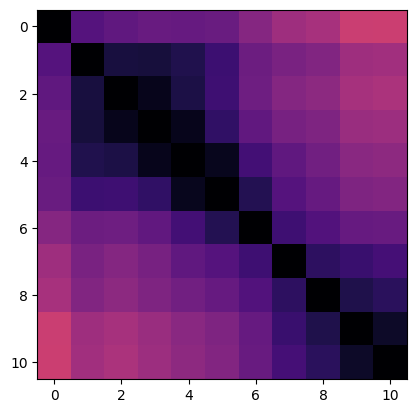

In [8]:
run_id = 1504482
run_dir = align_configs.loc[run_id]["run_dir"]
heatmap = align_results[run_dir]


plt.imshow(heatmap, cmap="magma_r", vmin=0.5, vmax=0.8)

#### Sanity check

In [9]:
alignment_sanity_check_score(heatmap, k=1)

0.9090909090909091

# Visualize Concepts

In [10]:
def load_model_id(run_id):
    cfg = align_configs.loc[run_id]
    df_run = pd.read_csv(os.path.join(cfg["run_dir"], "run_configs.csv")).set_index(
        ["vcl", "representation_model", "feature_layer"]
    )
    model_run_id_1 = int(
        df_run.loc[cfg.vcl, cfg.model1, cfg.fl1]["config_path"].split("/")[3]
    )
    model_run_id_2 = int(
        df_run.loc[cfg.vcl, cfg.model2, cfg.fl2]["config_path"].split("/")[3]
    )
    return model_run_id_1, model_run_id_2

## Concept atlas

Load pairwise distances between concepts within the same representation

In [11]:
# Load pairwise distances between concepts within the same representation (cfg.fl1=cfg.fl2)

run_id = 1504484

run_dir = align_configs.loc[run_id]["run_dir"]
with open(os.path.join(run_dir, "alignment_cw.pkl"), "rb") as f:
    alignment_cw = pickle.load(f)

In [12]:
# Find model run_id
model1_run_id, _ = load_model_id(run_id)

We compute a 2-dimensional UMAP embedding based on the pairwise distances between 

In [13]:
# UMAP embedding of concept distances
mds = UMAP(
    n_components=2, metric="precomputed", n_neighbors=70, min_dist=0.01, random_state=40
)
points_2d = mds.fit_transform(alignment_cw["alignment"])
kmeans_label = KMeans(n_clusters=30, random_state=40).fit_predict(points_2d)

/opt/anaconda3/envs/nlmcd-env/lib/python3.10/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/opt/anaconda3/envs/nlmcd-env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/anaconda3/envs/nlmcd-env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


To provide an overview of the semantic organization of the concepts, we generate a concept label from the ImageNet-1k labels of the cluster members. These labels are then mapped to more general labels using the WordNet hierarchy. We apply a majority voting approach and select the WordNet label that is most frequently represented by the concept cluster members for each concept.

In [14]:
# Load hard assignments for cluster label majority vote
hard_assignments = load_concept_activations(
    df.loc[[model1_run_id]],
    exp_dir,
    train=True,
    cluster_assignment="hard_clustering",
    filename_root="clustering.npy",
    take_parent=False,
)

# load patch gt labels
meta_class_file = "../data/imagenet_meta_classes.csv"
gt_meta_labels = load_groundtruth(
    df.loc[[model1_run_id]],
    exp_dir,
    gt_type="gt_meta",
    data_root="../../data/ImageNet-complete/",
    meta_class_file=meta_class_file,
)
gt_meta_labels = gt_meta_labels.argmax(axis=1)  # undo one-hot

# load str labels for meta gt
in_meta_classes = pd.read_csv(meta_class_file, index_col=0)
in_meta_classes["meta_class_num"] = in_meta_classes["meta_class_num"].astype(int)
meta_label_str_mapping = (
    in_meta_classes.drop_duplicates("meta_class_num")
    .set_index("meta_class_num")["meta_class_str"]
    .to_dict()
)
meta_label_str_mapping[max(meta_label_str_mapping.keys()) + 1] = "unknown"

# majority vote for cluster label
cluster_labels = np.unique(hard_assignments[("hard_clustering", model1_run_id)])[1:]
cluster_meta_label_mapping = []
consistency = []
for cl in cluster_labels:
    meta_label, counts = np.unique(
        gt_meta_labels[hard_assignments[("hard_clustering", model1_run_id)] == cl],
        return_counts=True,
    )
    consistency.append(counts.max() / counts.sum())
    cluster_meta_label = meta_label[counts.argmax()]
    cluster_meta_label_mapping.append(cluster_meta_label)

cluster_meta_label_mapping = np.array(cluster_meta_label_mapping)

Finally, we plot the UMAP embedding of the concepts and color-code them by the WordNet majority vote label and the kmeans labels.

/var/folders/6f/5p4_5nlj7qx7tlr7hyc2gg9wsrprj8/T/ipykernel_20811/893958836.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.cm.get_cmap('Set1', 9).colors,
/var/folders/6f/5p4_5nlj7qx7tlr7hyc2gg9wsrprj8/T/ipykernel_20811/893958836.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.cm.get_cmap('Set2', 8).colors,
/var/folders/6f/5p4_5nlj7qx7tlr7hyc2gg9wsrprj8/T/ipykernel_20811/893958836.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.cm.get_cmap('Set3', 12)

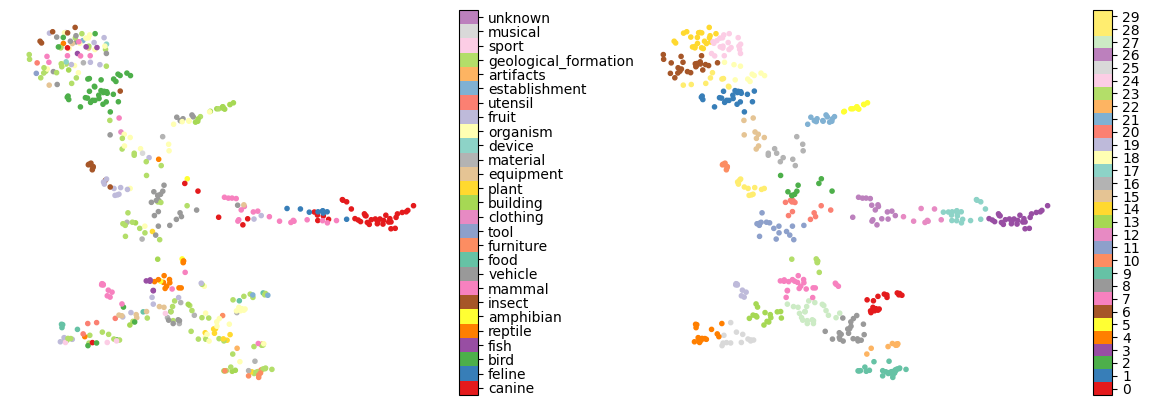

In [15]:
# Plot the concept atlas with WordNet majority vote and kmeans labels:

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

all_labels_tuple = (
    [
        "canine",
        "feline",
        "bird",
        "fish",
        "reptile",
        "amphibian",
        "insect",
        "mammal",
        "vehicle",
        "food",
        "furniture",
        "tool",
        "clothing",
        "building",
        "plant",
        "equipment",
        "material",
        "device",
        "organism",
        "fruit",
        "utensil",
        "establishment",
        "artifacts",
        "geological_formation",
        "sport",
        "musical",
        "unknown",
    ],
    np.unique(kmeans_label),
)

for i, labels in enumerate((cluster_meta_label_mapping, kmeans_label)):
    all_labels = all_labels_tuple[i]

    colors = np.concatenate(
        [
            plt.cm.get_cmap("Set1", 9).colors,
            plt.cm.get_cmap("Set2", 8).colors,
            plt.cm.get_cmap("Set3", 12).colors,
        ]
    )[: len(all_labels)]
    cmap = plt.cm.colors.ListedColormap(colors)

    ncolors = len(all_labels)
    norm = BoundaryNorm(boundaries=range(len(all_labels) + 1), ncolors=ncolors)

    cbar = ax[i].scatter(
        points_2d[:, 0], points_2d[:, 1], marker=".", c=labels, cmap=cmap, norm=norm
    )
    cbar = plt.colorbar(cbar)

    # Set the ticks correctly
    # Set the ticks correctly
    cbar.set_ticks(
        np.linspace(0.5, ncolors - 0.5, ncolors)
    )  # Set the ticks to match the labels
    cbar.set_ticklabels(all_labels)  # Set the labels
    cbar.ax.minorticks_off()

    # Turn off the axes
    ax[i].axis("off")

Now, we want to select some concepts for visualization. To do so, we sample random concepts from a selection of kmeans clusters of the concept atlas

In [16]:
# select all kmeans groups
kmeans_to_visualize = np.unique(kmeans_label)

In [17]:
# or select manually:
kmeans_to_visualize = [1, 2, 3]

In [18]:
# Choose concepts for visualization

vis_dict = {}

# number of concepts to visualize
n_select = 5


for c in kmeans_to_visualize:
    kmeans_df = pd.DataFrame(
        {"kmeans_label": kmeans_label, "concept": np.arange(len(kmeans_label))}
    )
    meta_cluster = kmeans_df[kmeans_df["kmeans_label"] == c]["concept"].values
    np.random.seed(42)
    concepts_to_vis = list(
        np.random.choice(
            meta_cluster, size=min((kmeans_label == c).sum(), n_select), replace=False
        )
    )

    vis_dict[f"kmeans_{c}"] = concepts_to_vis


visualization_dir = "../results/cluster_visualization"
filename_1 = f"{run_id}_{model1_run_id}.pkl"

with open(os.path.join(visualization_dir, filename_1), "wb") as f:
    pickle.dump(vis_dict, f)

f"python3 executable_scripts/cluster_visualization.py run_id_align={run_id} run_id={model1_run_id}"

'python3 executable_scripts/cluster_visualization.py run_id_align=1504484 run_id=1504197'

To visualize the concepts, run the command from above:

```bash
python executable_scripts/cluster_visualization.py cls=False run_id_align=1504484 run_id=1504197
```


Some examples:

*KMeans cluster 0* 
Concept 1           |  Concept 2 |  Concept 3
:-------------------------:|:-------------------------:|:-------------------------:
![](../results/cluster_visualization/1504484/1504197/1504484_1504197_kmeans_0_0_182.svg) | ![](../results/cluster_visualization/1504484/1504197/1504484_1504197_kmeans_0_1_184.svg) | ![](../results/cluster_visualization/1504484/1504197/1504484_1504197_kmeans_0_2_277.svg)


*KMeans cluster 1* 
Concept 1           |  Concept 2 |  Concept 3
:-------------------------:|:-------------------------:|:-------------------------:
![](../results/cluster_visualization/1504484/1504197/1504484_1504197_kmeans_1_0_236.svg) | ![](../results/cluster_visualization/1504484/1504197/1504484_1504197_kmeans_1_1_376.svg)| ![](../results/cluster_visualization/1504484/1504197/1504484_1504197_kmeans_1_2_79.svg)

## Differences between representations on concept level

Load pairwise distances between concepts of two diffffernt representations

In [19]:
run_id = 1504483

run_dir = align_configs.loc[run_id]["run_dir"]
with open(os.path.join(run_dir, "alignment_cw.pkl"), "rb") as f:
    alignment_cw = pickle.load(f)

model1_run_id, model2_run_id = load_model_id(run_id)

dist, matches = alignment_cw["alignment"], alignment_cw["cluster_match"]
dist_pairs = dist[matches[0], matches[1]]

In [24]:
align_configs.loc[run_id][["model1", "model2", "fl1", "fl2"]]

model1    vit_base_patch16_224.mae
model2    vit_base_patch16_224.mae
fl1                              6
fl2                              7
Name: 1504483, dtype: object

Show the pairwise-distance matrix:

(-0.5, 141.5, 106.5, -0.5)

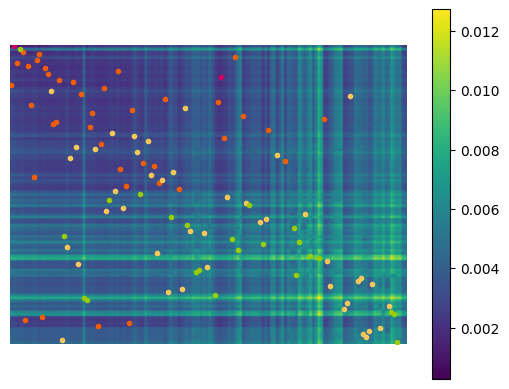

In [21]:
plt.imshow(dist)
plt.colorbar()

order = dist[matches[0], matches[1]].argsort()

portion_dict = {
    "dist-order_univeral": (0, 2),
    "dist-order_semi-universal": (2, 41),
    "dist-order_semi_unique": (41, 84),
    "dist-order_unique": (84, len(dist_pairs)),
}

portion_color = {
    "dist-order_univeral": "#CC015D",
    "dist-order_semi-universal": "#F45D00",
    "dist-order_semi_unique": "#FFC858",
    "dist-order_unique": "#97CC02",
}

for k in portion_dict:
    portion = portion_dict[k]
    # plt.scatter(matches[1][portion[0]:portion[1]], matches[0][portion[0]:portion[1]], marker='.', color=portion_color[k])
    plt.scatter(
        matches[1][order[portion[0] : portion[1]]],
        matches[0][order[portion[0] : portion[1]]],
        marker=".",
        color=portion_color[k],
    )

plt.axis("off")

Show the distribution of pairwise distances between matched concepts:

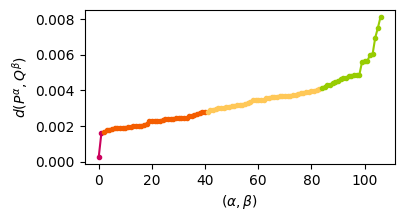

In [22]:
plt.figure(figsize=(4, 2))
for k in portion_dict:
    portion = portion_dict[k]
    plt.plot(
        np.arange(portion[0], portion[1]),
        dist_pairs[order][portion[0] : portion[1]],
        marker=".",
        color=portion_color[k],
    )

plt.ylabel(r"$ d(P^{\alpha},Q^{\beta})$")
plt.xlabel(r"$(\alpha,\beta)$")
plt.savefig(
    f"{visualization_dir}/alignment_dist_noorde_{run_id}.svg", bbox_inches="tight"
)

Select concepts from each portion for visualization

In [23]:
dict_1 = {}
dict_2 = {}

n_concept_to_visualize = 10

for k in portion_dict:
    portion = portion_dict[k]

    min_idx, max_idx = (
        (0, n_concept_to_visualize)
        if "universal" in k
        else (-n_concept_to_visualize, None)
    )
    dict_1[f"Portion_{k}"] = list(matches[0][order[portion[0] : portion[1]]])[
        min_idx:max_idx
    ]
    dict_2[f"Portion_{k}"] = list(matches[1][order[portion[0] : portion[1]]])[
        min_idx:max_idx
    ]

if dist.shape[0] > dist.shape[1]:
    concept_idx = np.arange(dist.shape[0])
    mask = ~np.isin(concept_idx, matches[0])
    dict_1["unmatched"] = list(concept_idx[mask])[:n_concept_to_visualize]
else:
    concept_idx = np.arange(dist.shape[1])
    mask = ~np.isin(concept_idx, matches[1])
    dict_2["unmatched"] = list(concept_idx[mask])[:n_concept_to_visualize]

visualization_dir = "../results/cluster_visualization"
filename_1 = f"{run_id}_{model1_run_id}.pkl"
with open(os.path.join(visualization_dir, filename_1), "wb") as f:
    pickle.dump(dict_1, f)
filename_2 = f"{run_id}_{model2_run_id}.pkl"
with open(os.path.join(visualization_dir, filename_2), "wb") as f:
    pickle.dump(dict_2, f)


print(
    f"python3 executable_scripts/cluster_visualization.py run_id_align={run_id} run_id={model1_run_id}"
)
print(
    f"python3 executable_scripts/cluster_visualization.py run_id_align={run_id} run_id={model2_run_id}"
)

python3 executable_scripts/cluster_visualization.py run_id_align=1504483 run_id=1504192
python3 executable_scripts/cluster_visualization.py run_id_align=1504483 run_id=1504193


To visualize the concepts, run the commands from above:

```bash
python3 executable_scripts/cluster_visualization.py run_id_align=1504483 run_id=1504192
python3 executable_scripts/cluster_visualization.py run_id_align=1504483 run_id=1504193
```


Some examples of matches concepts between two different representations:

*Universal Partition* 
MAE Layer 6        |  MAE Layer 7    
:-------------------------:|:-------------------------:
![](../results/cluster_visualization/1504483/1504192/1504483_1504192_Portion_dist-order_univeral_0_0.svg) | ![](../results/cluster_visualization/1504483/1504193/1504483_1504193_Portion_dist-order_univeral_0_1.svg)


*Unique Partition* 
MAE Layer 6        |  MAE Layer 7    
:-------------------------:|:-------------------------:
![](../results/cluster_visualization/1504483/1504192/1504483_1504192_Portion_dist-order_unique_0_106.svg) | ![](../results/cluster_visualization/1504483/1504193/1504483_1504193_Portion_dist-order_unique_0_138.svg)